In [70]:
from meal_identification.datasets.dataset_operations import get_root_dir
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_data(file='2024-11-15_500030__i5mins_d4hrs_c5g_l2hrs_n3.csv') -> pd.DataFrame:
    data_path='0_meal_identification/meal_identification/data/interim'
    project_root = get_root_dir()
    full_raw_loc_path = os.path.join(project_root, data_path)
    file_path = os.path.join(full_raw_loc_path, file)
    return pd.read_csv(file_path, usecols=['date', 'bgl', 'msg_type', 'day_start_shift'], parse_dates=['date'])

def generate_meal_periods(df: pd.DataFrame, meal_length=6, n_steps=1) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Add meal time "meal_length" after each ANNOUNCE_MEAL and calculate derivative. 1 meal length is one time step
    Basically, we wanted to create a period of meal time.

    Parameters
    ----------
        df: DataFrame containing the BGL data
        meal_length: Number of rows to label as ANNOUNCE_MEAL after each ANNOUNCE_MEAL
        n_steps: Number of time steps (time delta) for second derivative calculation
    Returns
    -------
        DataFrame with processed and smoothed data
    """
    copied_df = df.copy()

    print (f"Each meal lasts {meal_length*5} mins ({meal_length*10} rows)")
    meal_indices = copied_df[copied_df['msg_type'] == 'ANNOUNCE_MEAL'].index
    for idx in meal_indices:
        next_indices = range(idx, min(idx + meal_length, len(df)))

        # Set those rows' msg_type to ANNOUNCE_MEAL
        copied_df.loc[next_indices, 'msg_type'] = 'ANNOUNCE_MEAL'

    copied_df['bgl_rate'] = copied_df['bgl'].diff(periods=n_steps) / (5.0 * n_steps)  # divide by total minutes to get rate
    normalized_df = normalize_df(copied_df)
    return normalized_df

def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize numeric columns in the DataFrame using z-score normalization (StandardScaler).

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame to normalize

    Returns
    -------
    pd.DataFrame
        Normalized DataFrame with non-numeric columns preserved
    """
    # Create a copy to avoid modifying the original
    df_normalized = df.copy()

    # Calculate mean and std for each numeric column
    for column in df.columns:
        if column in ['bgl', 'bgl_rate']:  # Only normalize BGL-related columns
            mean = df[column].mean()
            std = df[column].std()

            # Avoid division by zero
            if std == 0:
                df_normalized[column] = 0
            else:
                df_normalized[column] = (df[column] - mean) / std

    return df_normalized

def to_chunk(df: pd.DataFrame, meal_length: int) -> list[pd.DataFrame]:
    """
    Creates temporal fan chart data from glucose measurements around meal announcements.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with datetime index and columns: 'bgl', 'msg_type'
    meal_length : float
        Length of a meal
    percentiles : list
        List of percentiles to calculate for the fan chart

    Returns:
    --------
    dict containing:
        - time_points: array of time points (in hours) relative to meal announcement
        - percentile_values: dictionary of percentile curves
        - count_per_timepoint: number of observations at each time point
    """
    chunks = []
    i = 0

    while i < len(df):
        # Exit if not enough rows left
        if i + meal_length > len(df):
            break

        # Check if current position contains ANNOUNCE_MEAL
        if df.iloc[i]['msg_type'] == 'ANNOUNCE_MEAL':
            # Extract chunk starting from meal announcement
            if i + meal_length <= len(df):
                chunk = df.iloc[i: (i+meal_length)].copy()
                chunks.append(chunk)
            i += meal_length
        else:
            # For non-meal periods, check if the next meal_length rows contain any ANNOUNCE_MEAL
            if i + meal_length <= len(df):
                potential_chunk = df.iloc[i: i+meal_length]
                # Check if there's a meal announcement in this potential chunk
                meal_indices = potential_chunk.index[potential_chunk['msg_type'] == 'ANNOUNCE_MEAL']

                if len(meal_indices) > 0:
                    # If there's a meal announcement, move i to that position
                    # Find the position of the first meal announcement relative to i
                    first_meal_pos = potential_chunk.index.get_loc(meal_indices[0])
                    i += first_meal_pos  # Move i to the meal announcement
                else:
                    # Only add the chunk if it's a complete chunk
                    if len(potential_chunk) == meal_length:
                        chunks.append(potential_chunk.copy())
                    i += meal_length
    return chunks

def plot_histograms(df: pd.DataFrame, file, bgl_bins=30, rate_bins=20):
    meal_df = df[df['msg_type'] == 'ANNOUNCE_MEAL']
    non_meal_df = df[df['msg_type'] != 'ANNOUNCE_MEAL']

    # Common axis parameters
    def style_axis(ax, title, xlabel):
        ax.set_title(title, pad=15, fontsize=12, fontweight='bold')
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=10)

    # Set fixed width for histogram
    bgl_min = min(meal_df['bgl'].min(), non_meal_df['bgl'].min())
    bgl_max = max(meal_df['bgl'].max(), non_meal_df['bgl'].max())
    rate_min = min(meal_df['bgl_rate'].min(), non_meal_df['bgl_rate'].min())
    rate_max = max(meal_df['bgl_rate'].max(), non_meal_df['bgl_rate'].max())

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    plt.title = file

    bgl_bins= np.linspace(bgl_min, bgl_max, bgl_bins + 1)
    rate_bins = np.linspace(rate_min, rate_max, rate_bins + 1)
    hist_params = dict(
        stat='density',
        alpha=0.5,  # Reduced alpha for better overlay visibility
        edgecolor='white',
        linewidth=1,
    )

    # Plot both distributions on the same axes
    sns.histplot(data=meal_df['bgl'], ax=ax1, color='r', bins=bgl_bins,
                label=f'Meal Events (n={len(meal_df):,})', **hist_params)
    sns.histplot(data=non_meal_df['bgl'], ax=ax1, color='b',bins=bgl_bins,
                label=f'Non-Meal Events (n={len(non_meal_df):,})', **hist_params)

    style_axis(ax1, 'Blood Glucose Level Distribution - Meal vs Non-Meal Events', 'Blood Glucose Level (mg/dL)')
    ax1.set_xlim(bgl_min, bgl_max)
    ax1.legend(frameon=True, fontsize=10)

    sns.histplot(data=meal_df['bgl_rate'], ax=ax2, color='r', bins=rate_bins,
                label=f'Meal Events (n={len(meal_df):,})', **hist_params)
    sns.histplot(data=non_meal_df['bgl_rate'], ax=ax2, color='b', bins=rate_bins,
                label=f'Non-Meal Events (n={len(non_meal_df):,})', **hist_params)

    style_axis(ax1, 'Blood Glucose Level Distribution - Meal vs Non-Meal Events', 'Blood Glucose Level')
    ax1.set_xlim(bgl_min, bgl_max)
    ax1.legend(frameon=True, fontsize=10)

    style_axis(ax2, 'Blood Glucose Rate Distribution - Meal vs Non-Meal Events', 'Blood Glucose Rate')
    ax2.set_xlim(rate_min, rate_max)
    ax2.legend(frameon=True, fontsize=10)

    plt.tight_layout()

    # statistics
    print(f"BGL range: {bgl_min:.1f} to {bgl_max:.1f}")
    print(f"Rate range: {rate_min:.1f} to {rate_max:.1f}")
    print(f"\nNumber of meal rows: {len(meal_df)}")
    print(f"Number of non-meal rows: {len(non_meal_df)}")

def plot_fan_chart(chunks: [pd.DataFrame]):
    # Create time points (x-axis) based on chunk length
    plt.figure(figsize=(12, 6))

    # If it is a meal chunk, use red line instead, else blue
    for chunk in chunks:
        color = 'r' if 'ANNOUNCE_MEAL' in chunk['msg_type'].values else 'b'
        plt.plot(range(len(chunk)), chunk['bgl'].values, color=color, alpha=0.1)

    plt.title('Fan Chart Glucose Chunks (Red = Meal, Blue = Non-meal)')
    plt.xlabel('Time Point')
    plt.ylabel('Blood Glucose Level')
    plt.grid(True, alpha=0.3)

    plt.show()

## Generate data
 - Adjust `index` to see different files in `data/interim` </br>
 - Adjust `meal_length` to change meal period. Each row is 5 mins. Default to 6 rows (30 mins)
 - Adjust `n_step` to change the time step of derivative
 - Adjust `bgl_bins` to change number of bins for bgl
 - Adjust `rate_bins` to change number of bins of derivative
 - Adjust `use_fan_chart` to change if you want a normal histogram or a fan chart

---------------

File selected: 2024-11-15_679372__i5mins_d4hrs_c5g_l3hrs_n3.csv
Each meal lasts 150 mins (300 rows)


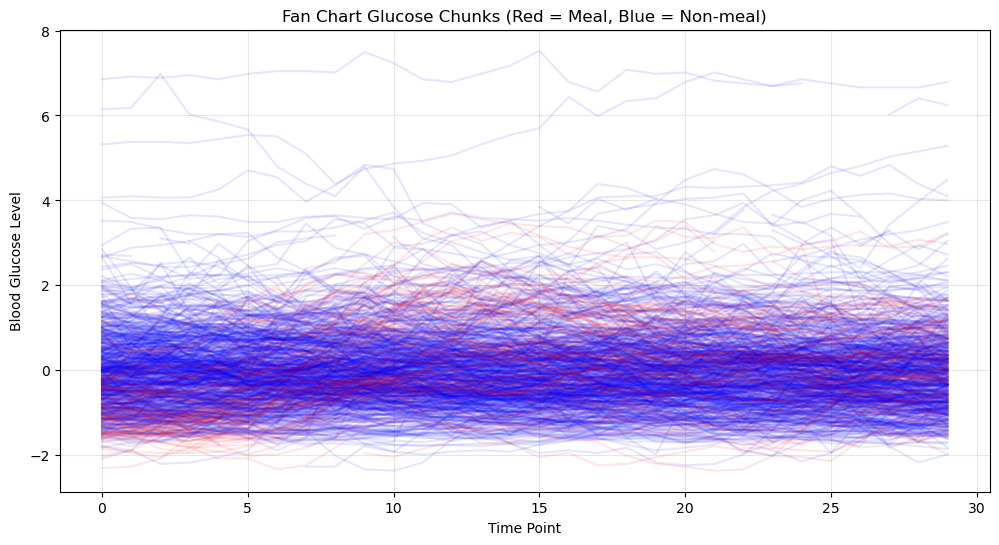

In [71]:
index = -4
meal_length = 30
n_step = 1
bgl_bins = 50
rate_bins = 40
use_fan_chart = True

# Choose an index of the file
csv_files = [f for f in os.listdir('../data/interim') if f.endswith('.csv')]
# print("csv files: ", csv_files)


print('---------------\n')
file = csv_files[index]
# Or use the file name directly
# file = '2024-11-18_adu001__i5mins_d4hrs_c5g_l3hrs_n3.csv'
print(f"File selected: {file}")
df = load_data(file)

normalized_df = generate_meal_periods(df, meal_length=meal_length, n_steps=1)
chunks = to_chunk(normalized_df, meal_length=meal_length)

# use only one because graphs are quite expensive to generate
if use_fan_chart:
    plot_fan_chart(chunks)
else:
    plot_histograms(normalized_df, file, bgl_bins=50, rate_bins=50)

In [72]:
chunks[5]

,date,bgl,msg_type,day_start_shift,bgl_rate
163,2024-07-01 13:35:00-04:00,0.228270,ANNOUNCE_MEAL,2024-07-01,0.000034
164,2024-07-01 13:40:00-04:00,0.420285,ANNOUNCE_MEAL,2024-07-01,0.790342
165,2024-07-01 13:45:00-04:00,0.516292,ANNOUNCE_MEAL,2024-07-01,0.395188
166,2024-07-01 13:50:00-04:00,0.708306,ANNOUNCE_MEAL,2024-07-01,0.790342
167,2024-07-01 13:55:00-04:00,0.708306,ANNOUNCE_MEAL,2024-07-01,0.000034
168,2024-07-01 14:00:00-04:00,0.612299,ANNOUNCE_MEAL,2024-07-01,-0.395119
169,2024-07-01 14:05:00-04:00,0.644302,ANNOUNCE_MEAL,2024-07-01,0.131752
170,2024-07-01 14:10:00-04:00,0.516292,ANNOUNCE_MEAL,2024-07-01,-0.526837
171,2024-07-01 14:15:00-04:00,0.740309,ANNOUNCE_MEAL,2024-07-01,0.922060
172,2024-07-01 14:20:00-04:00,0.868318,ANNOUNCE_MEAL,2024-07-01,0.526906


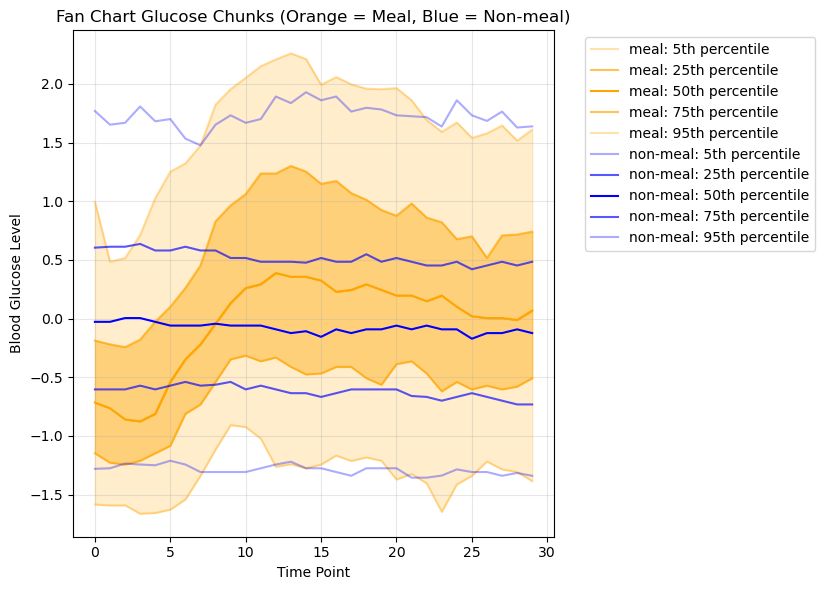

In [73]:
# Create time points (x-axis) based on chunk length
meal_plot = []
non_meal_plot = []
chunk_length = len(chunks[0])
# If it is a meal chunk, use red line instead, else blue
for chunk in chunks:
    meal_plot.append(chunk['bgl']) if 'ANNOUNCE_MEAL' in chunk['msg_type'].values else non_meal_plot.append(chunk['bgl'])

meal_plot = np.array(meal_plot)
non_meal_plot = np.array(non_meal_plot)

# Define the percentiles to plot
percentiles = [5, 25, 50, 75, 95]

# Calculate the percentiles for each timestep
percentile_data_meal = np.nanpercentile(meal_plot, percentiles, axis=0)
percentile_data_non_meal = np.nanpercentile(non_meal_plot, percentiles, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Fan Chart Glucose Chunks (Orange = Meal, Blue = Non-meal)')
plt.xlabel('Time Point')
plt.ylabel('Blood Glucose Level')
plt.grid(True, alpha=0.3)

# Define alpha values for the filled areas
alpha_values = [0.33, 0.66, 1, 0.66, 0.33]

for i, percentile in enumerate(percentiles):
    ax.plot(range(chunk_length), percentile_data_meal[i, :], label=f'meal: {percentile}th percentile', color='orange', alpha=alpha_values[i])

for i, percentile in enumerate(percentiles):
    ax.plot(range(chunk_length), percentile_data_non_meal[i, :], label=f'non-meal: {percentile}th percentile', color='blue', alpha=alpha_values[i])


ax.fill_between(range(chunk_length), percentile_data_meal[0, :], percentile_data_meal[-1, :], color='orange', alpha=0.2)
ax.fill_between(range(chunk_length), percentile_data_meal[1, :], percentile_data_meal[-2, :], color='orange', alpha=0.4)
ax.fill_between(range(chunk_length), percentile_data_meal[2, :], percentile_data_meal[2, :], color='orange', alpha=0.6)


ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

### Example Code:

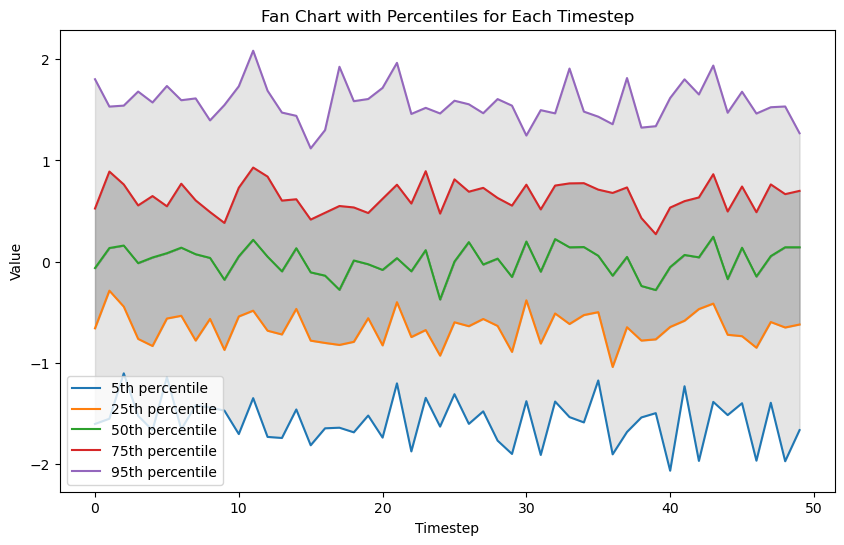

In [74]:
# Generate sample data
# Assume we have 100 time series chunks, each of length 50
num_chunks = 100
chunk_length = 50

# Generate random data for demonstration purposes
# Replace this with your actual data loading/generation code
data = np.random.randn(num_chunks, chunk_length)
# Define the percentiles to plot
percentiles = [5, 25, 50, 75, 95]

# Calculate the percentiles for each timestep
percentile_data = np.percentile(data, percentiles, axis=0)

# Create the fan chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the percentiles
for i, percentile in enumerate(percentiles):
    ax.plot(range(chunk_length), percentile_data[i, :], label=f'{percentile}th percentile')

# Fill between the percentiles to create the fan chart effect
ax.fill_between(range(chunk_length), percentile_data[0, :], percentile_data[-1, :], color='gray', alpha=0.2)
ax.fill_between(range(chunk_length), percentile_data[1, :], percentile_data[-2, :], color='gray', alpha=0.4)
ax.fill_between(range(chunk_length), percentile_data[2, :], percentile_data[2, :], color='gray', alpha=0.6)

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Value')
ax.set_title('Fan Chart with Percentiles for Each Timestep')
ax.legend()

# Show the plot
plt.show()

In [75]:
data.shape

(100, 50)